# Assignment 3:

In [1]:
#import packages

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

In [2]:
#data

data = pd.read_csv(r'C:\Users\USP\Desktop\MFE 2022 Preprogram courses\PYTHON\Assignments\Assignment 3\data\hw3.csv')
df = pd.DataFrame(data)
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.15163,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.23000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.74700,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.04010,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.90900,NaN,SOL,SOL


* Some Useful observations:

In [3]:
#info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2667 non-null   object 
 1   open       2667 non-null   float64
 2   high       2163 non-null   float64
 3   low        2378 non-null   float64
 4   close      2531 non-null   float64
 5   volume     2667 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2667 non-null   object 
 8   chain      2667 non-null   object 
dtypes: float64(6), object(3)
memory usage: 187.6+ KB


* We see there are 2667 observations but VolumeUSD is Zero and missing values in low, high, and close values.

In [4]:
#token naming

df['token'].value_counts()

BTC                                   323
COMP                                  322
CRV                                   318
SOL                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">SOL</span>      16
<span name="tokenName">AAVE</span>     16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64

* We see there are some html tags in the token naming.

In [5]:
# duplicates

df.duplicated().sum()

307

* There are duplicates.

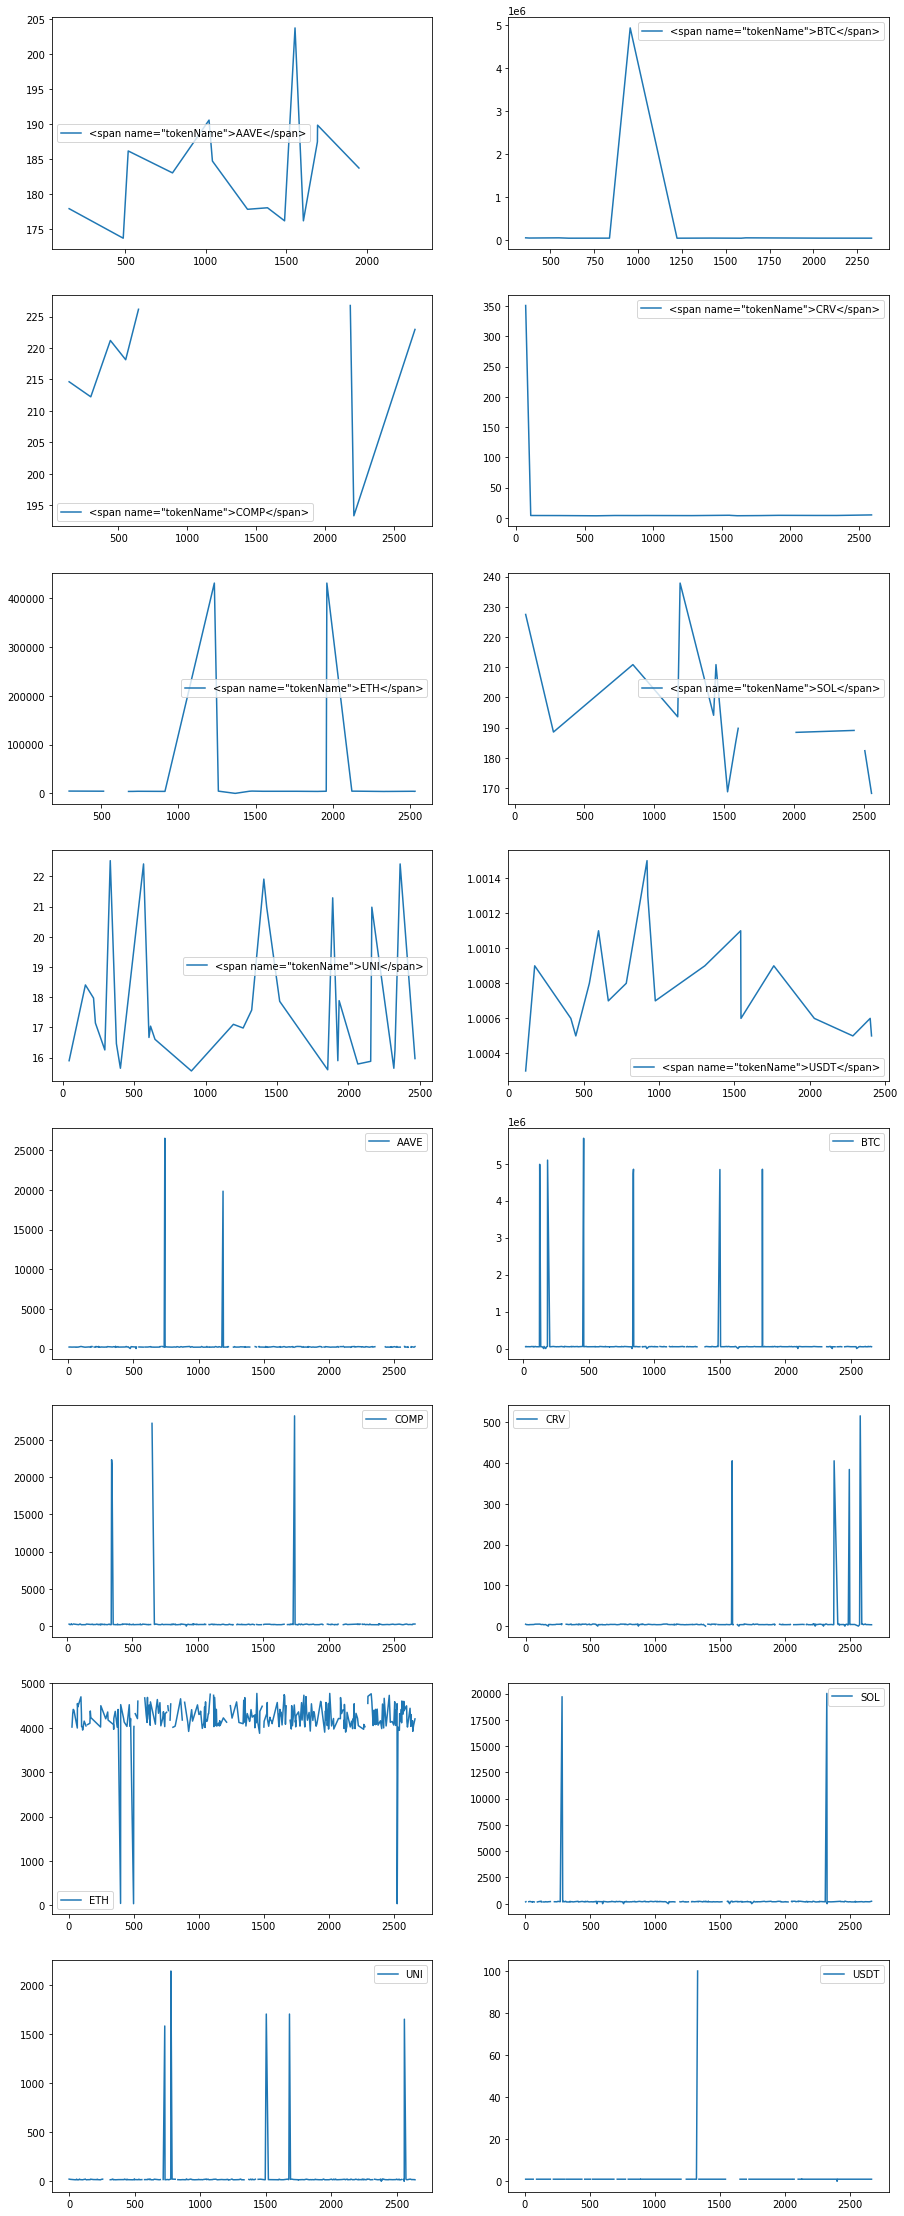

In [6]:
# visualize for the close only (as sample)

tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


* It is clear the presence of outliers and missing data.

### 1- Let's format the names by removing the html tags
### 2- Let's remove the duplicated rows
### 3- Let's use a heuristic for missing high, low, and close price (different strategy for each column)

## Cleaning Token names; Removing html tags:

In [7]:
# extracting the token column to treat the token names

list_token = df["token"].tolist()
len(list_token)

2667

In [8]:
# clean and replacing

from bs4 import BeautifulSoup

new_list_token = []

for _ in list_token:
    x = BeautifulSoup(_, "lxml").text
    new_list_token.append(x)

new_list_token_df = pd.DataFrame(new_list_token)


df["token"] = new_list_token_df


In [9]:
# validity check

df.groupby("token").size()

token
AAVE    328
BTC     337
COMP    332
CRV     335
ETH     326
SOL     334
UNI     342
USDT    333
dtype: int64

## Deleting Duplicates:

In [10]:
# dropping duplicates

df = df.drop_duplicates()
df.duplicated().sum()


0

In [11]:
df.groupby("token").size()

token
AAVE    295
BTC     295
COMP    295
CRV     295
ETH     295
SOL     295
UNI     295
USDT    295
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2360 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2360 non-null   object 
 1   open       2360 non-null   float64
 2   high       1910 non-null   float64
 3   low        2104 non-null   float64
 4   close      2244 non-null   float64
 5   volume     2360 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2360 non-null   object 
 8   chain      2360 non-null   object 
dtypes: float64(6), object(3)
memory usage: 184.4+ KB


In [13]:
# re-arranging the df

df = df.sort_values(["token" , "ts"])

## Missing Values:

In [14]:
# high and low filling with previous hour values (no major changes within one hour so similir occur is highly probable)

df[["high","low"]] = df[["high","low"]].fillna(method="ffill")

In [15]:
# close filling with the average of low and high

df.loc[df['close'].isnull(), 'close'] = 0.5 * (df.loc[df['close'].isnull(), 'high'] + df.loc[df['close'].isnull(), 'low'])

## Outliers:

In [16]:
# checking for the high (high values) outliers

df.loc[df.high / df.open >= 2]

,ts,open,high,low,close,volume,volumeUSD,token,chain
1653,2021-12-01 00:00:00,210.312,4021.99,208.432,208.676,70031.618,NaN,SOL,SOL


In [17]:
# adjusting

df.loc[df.high / df.open >= 2, 'high'] = 0.5 * (df.loc[df.high / df.open >= 2, 'open'] + df.loc[df.close / df.open >= 2, 'low'])

In [18]:
# checking for the high (low values) outliers

df.loc[df.high / df.open <= 0.5]

,ts,open,high,low,close,volume,volumeUSD,token,chain


In [19]:
# checking for the low (high values) outliers

df.loc[df.low / df.open >= 2]

,ts,open,high,low,close,volume,volumeUSD,token,chain


In [20]:
# checking for the low (low values) outliers

df.loc[df.low / df.open <= 0.5]

,ts,open,high,low,close,volume,volumeUSD,token,chain


In [21]:
# checking for the close (high values) outliers

df.loc[df.close / df.open >= 2]

,ts,open,high,low,close,volume,volumeUSD,token,chain
741,2021-12-01 11:00:00,266.9360,267.9630,264.2370,26501.50,1.018631e+03,NaN,AAVE,ETH
1188,2021-12-05 12:00:00,198.8770,199.5750,196.7450,19832.40,2.262924e+03,NaN,AAVE,ETH
462,2021-12-02 23:00:00,56904.6500,56952.8100,56639.4900,5688883.00,3.821792e+02,NaN,BTC,BTC
840,2021-12-04 08:00:00,47711.3400,47869.7300,46750.0000,4734782.00,1.661132e+03,NaN,BTC,BTC
955,2021-12-05 11:00:00,49113.5500,49584.5100,48817.1500,4936795.00,6.211598e+02,NaN,BTC,BTC
187,2021-12-07 08:00:00,51224.9900,51398.2600,50883.3400,5097338.00,4.433800e+02,NaN,BTC,BTC
842,2021-12-09 16:00:00,48600.0100,48806.9000,48100.0000,4850319.00,1.509216e+03,NaN,BTC,BTC
1501,2021-12-10 21:00:00,48123.2900,48479.7800,47682.2000,4842749.00,7.488489e+02,NaN,BTC,BTC
127,2021-12-12 14:00:00,49542.3900,49332.2800,49534.7100,4983812.00,3.426704e+02,NaN,BTC,BTC
1740,2021-12-01 06:00:00,282.6500,283.7300,282.0000,28222.00,3.701940e+02,NaN,COMP,ETH


In [22]:
# adjusting

df.loc[df.close / df.open >= 2, 'close'] = 0.5 * (df.loc[df.close / df.open >= 2, 'high'] + df.loc[df.close / df.open >= 2, 'low'])
df

,ts,open,high,low,close,volume,volumeUSD,token,chain
2199,2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.0780,2730.299,NaN,AAVE,ETH
932,2021-12-01 01:00:00,257.1490,266.2490,255.2700,264.8160,5752.541,NaN,AAVE,ETH
2582,2021-12-01 02:00:00,264.7550,266.1870,262.5970,263.1250,1559.330,NaN,AAVE,ETH
363,2021-12-01 03:00:00,263.1840,266.1870,262.5970,266.2570,1647.398,NaN,AAVE,ETH
1758,2021-12-01 04:00:00,266.3840,267.0240,264.2840,265.5020,829.993,NaN,AAVE,ETH
...,...,...,...,...,...,...,...,...,...
1814,2021-12-13 02:00:00,1.0005,1.0006,1.0004,1.0004,7133859.470,NaN,USDT,USDT
614,2021-12-13 03:00:00,1.0004,1.0006,1.0004,1.0006,4337884.530,NaN,USDT,USDT
1992,2021-12-13 04:00:00,1.0006,1.0006,1.0004,1.0006,2928892.910,NaN,USDT,USDT
859,2021-12-13 05:00:00,1.0006,1.0006,1.0005,1.0006,2178755.170,NaN,USDT,USDT


In [23]:
# checking for the close (low values) outliers

df.loc[df.close / df.open <= 0.5]

,ts,open,high,low,close,volume,volumeUSD,token,chain
520,2021-12-01 17:00:00,265.2620,269.1060,262.9060,2.632300,9.809190e+02,NaN,AAVE,ETH
475,2021-12-02 08:00:00,245.8090,247.5180,245.7290,2.467160,3.166740e+02,NaN,AAVE,ETH
158,2021-12-03 12:00:00,56891.7000,57209.7000,56858.0200,570.337400,1.897550e+02,NaN,BTC,BTC
173,2021-12-07 07:00:00,50941.5000,51272.8300,50936.0500,512.250000,3.124719e+02,NaN,BTC,BTC
944,2021-12-10 02:00:00,48051.1000,48579.4100,47797.8800,484.367900,4.690459e+02,NaN,BTC,BTC
1639,2021-12-10 08:00:00,47875.2900,48048.3400,47568.0600,476.863200,7.834112e+02,NaN,BTC,BTC
2544,2021-12-12 15:00:00,49831.3000,49960.0000,49549.1900,499.086700,3.623237e+02,NaN,BTC,BTC
912,2021-12-05 18:00:00,210.7000,214.7300,208.9300,2.145100,1.282728e+03,NaN,COMP,ETH
2230,2021-12-01 00:00:00,4.8830,5.0723,4.8264,0.050295,3.395810e+05,NaN,CRV,ETH
1643,2021-12-03 05:00:00,4.5835,4.6518,4.5533,0.046530,8.807282e+04,NaN,CRV,ETH


In [24]:
# adjusting

df.loc[df.close / df.open <= 2, 'close'] = 0.5 * (df.loc[df.close / df.open <= 2, 'high'] + df.loc[df.close / df.open <= 2, 'low'])
df

,ts,open,high,low,close,volume,volumeUSD,token,chain
2199,2021-12-01 00:00:00,257.1020,260.7750,255.3450,258.06000,2730.299,NaN,AAVE,ETH
932,2021-12-01 01:00:00,257.1490,266.2490,255.2700,260.75950,5752.541,NaN,AAVE,ETH
2582,2021-12-01 02:00:00,264.7550,266.1870,262.5970,264.39200,1559.330,NaN,AAVE,ETH
363,2021-12-01 03:00:00,263.1840,266.1870,262.5970,264.39200,1647.398,NaN,AAVE,ETH
1758,2021-12-01 04:00:00,266.3840,267.0240,264.2840,265.65400,829.993,NaN,AAVE,ETH
...,...,...,...,...,...,...,...,...,...
1814,2021-12-13 02:00:00,1.0005,1.0006,1.0004,1.00050,7133859.470,NaN,USDT,USDT
614,2021-12-13 03:00:00,1.0004,1.0006,1.0004,1.00050,4337884.530,NaN,USDT,USDT
1992,2021-12-13 04:00:00,1.0006,1.0006,1.0004,1.00050,2928892.910,NaN,USDT,USDT
859,2021-12-13 05:00:00,1.0006,1.0006,1.0005,1.00055,2178755.170,NaN,USDT,USDT


## VolumeUSD by chain

In [25]:
df_chain = df.groupby("chain").sum()
df_chain

,open,high,low,close,volume,volumeUSD
chain,,,,,,
BTC,1.508538e+07,1.517406e+07,1.498459e+07,1.507933e+07,2.160914e+05,0.0
ETH,1.389419e+06,1.399560e+06,1.378070e+06,1.388815e+06,9.709982e+07,0.0
SOL,5.771378e+04,5.817889e+04,5.706016e+04,5.751531e+04,2.061130e+07,0.0
USDT,2.952624e+02,2.953609e+02,2.952160e+02,2.952885e+02,1.006809e+09,0.0


In [26]:
volumeUSD_chain = df_chain["volume"]*df_chain["close"]

In [27]:
volumeUSD_chain

chain
BTC     3.258513e+12
ETH     1.348537e+14
SOL     1.185465e+12
USDT    2.972992e+11
dtype: float64

## Visualizing the data over low, high, and close values

In [28]:
df = df.set_index('ts')

---------------------------------------------------Close Values-------------------------------------------------


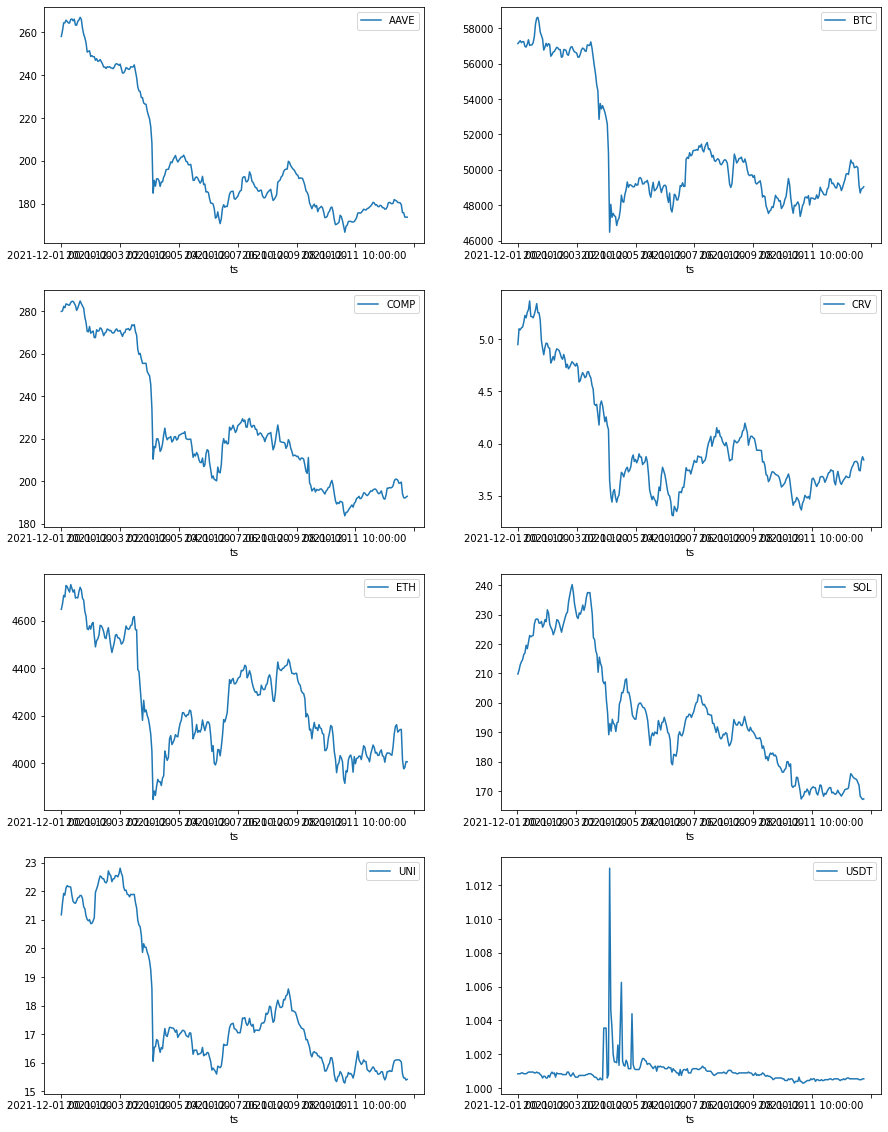

In [29]:

print("---------------------------------------------------Close Values-------------------------------------------------")

tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1
    
    


---------------------------------------------------High Values-------------------------------------------------


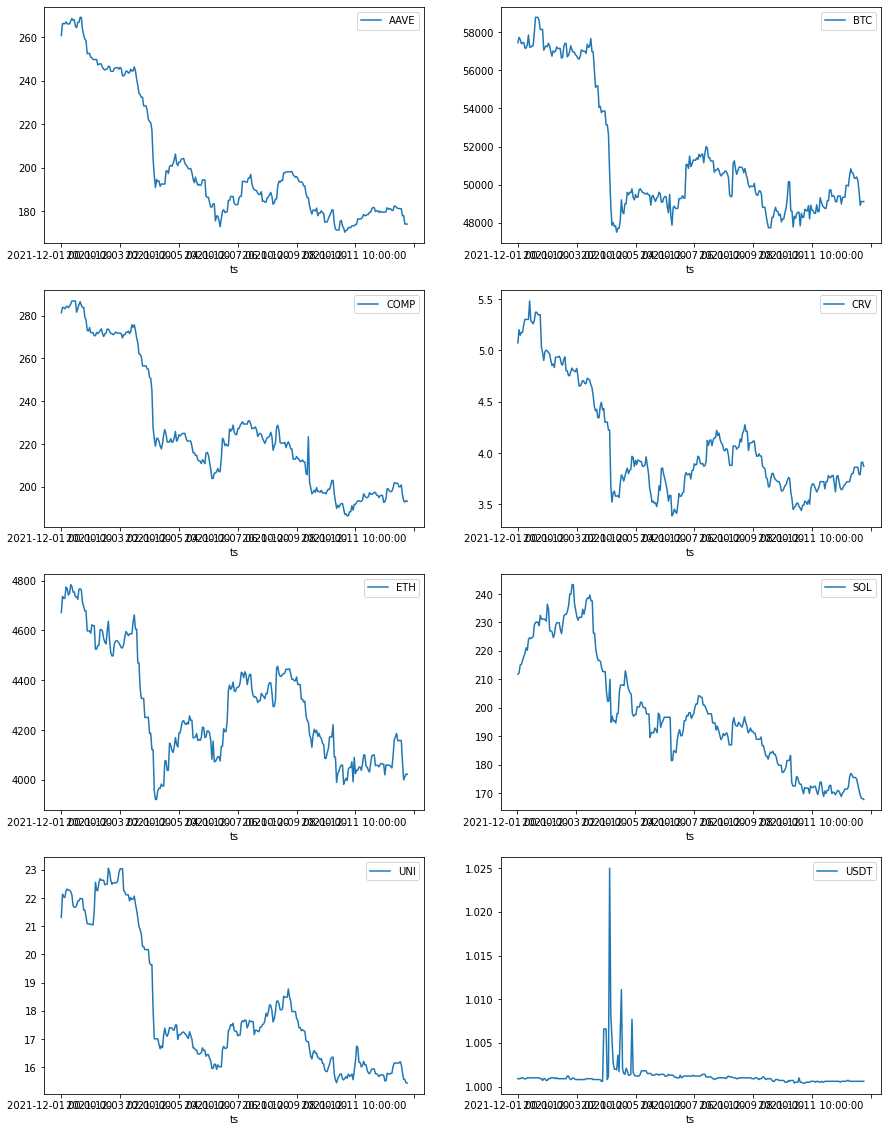

In [30]:

print("---------------------------------------------------High Values-------------------------------------------------")

tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'high']].groupby('token'):
    df_token['high'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1
    
    


---------------------------------------------------Low Values-------------------------------------------------


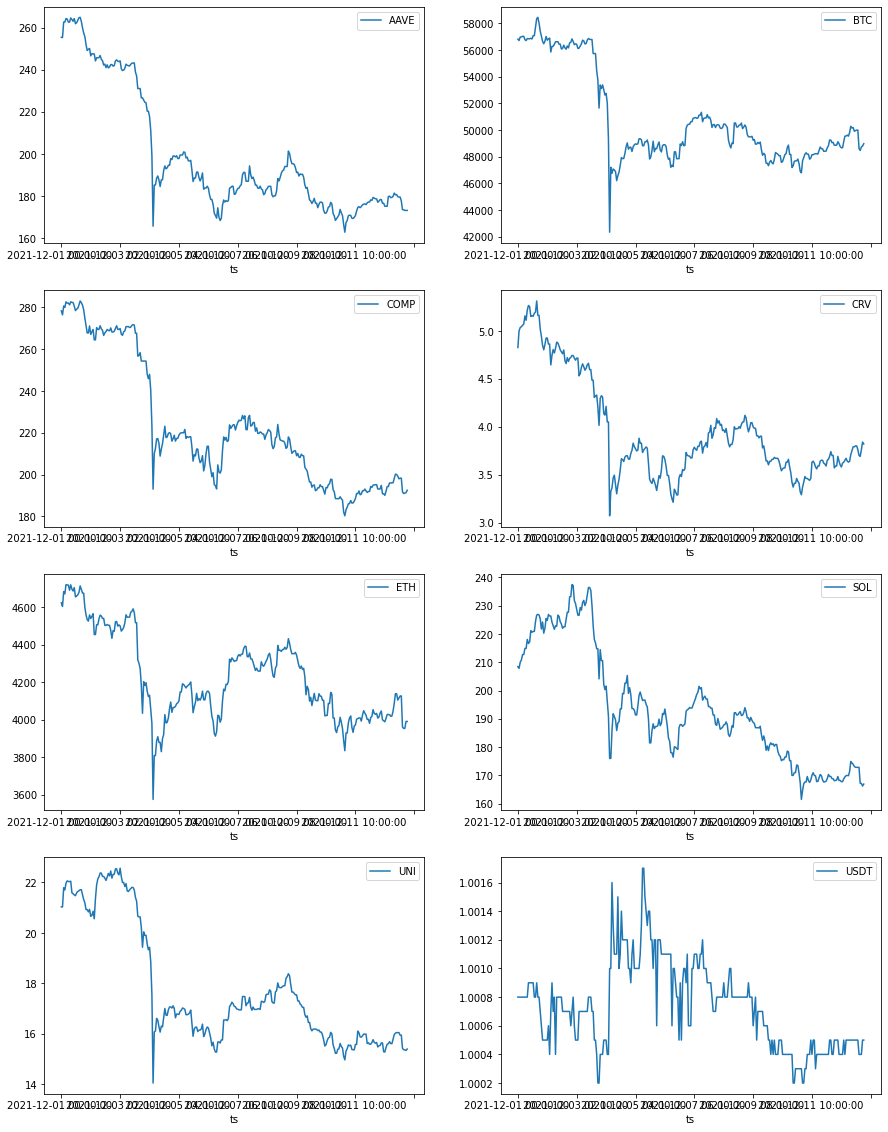

In [31]:

print("---------------------------------------------------Low Values-------------------------------------------------")

tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'low']].groupby('token'):
    df_token['low'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1
    
    
